# Binary Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 6
### David Lowe
### April 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset contains various measurements of breast tissue samples for cancer diagnosis. It contains measurements such as the thickness of the clump, the uniformity of cell size and shape, the marginal adhesion, and so on. Dr. William H. Wolberg of the University of Wisconsin Hospitals in Madison is the original provider of this dataset.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 94.29% with the test dataset. After tuning the hyperparameters, the best model processed the training dataset with an accuracy score of 97.33%. Furthermore, the final model processed the test dataset with an accuracy measurement of 97.14%, which was consistent with the training result.]

CONCLUSION: For this dataset, the model built using TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29]

One potential source of performance benchmarks: [https://www.kaggle.com/uciml/breast-cancer-wisconsin-data]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [2]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [3]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [4]:
# Set the random seed number for reproducible results
seedNum = 888

In [5]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [6]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.he_uniform(seed=seedNum)
default_epoch = 25
default_batch = 32

Num GPUs Available:  0


In [7]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [8]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [9]:
if (notifyStatus): email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [10]:
if (notifyStatus): email_notify("Task 2. Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [11]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
attrNames = ['attr' + str(i).zfill(2) for i in range(1,10)]
colNames = ['id'] + attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, na_values=['?'])

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,target
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4
6,1018099,1,1,1,1,2,10.0,3,1,1,2
7,1018561,2,1,2,1,2,1.0,3,1,1,2
8,1033078,2,1,1,1,2,1.0,1,1,5,2
9,1033078,4,2,1,1,2,1.0,2,1,1,2


In [12]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      699 non-null    int64  
 1   attr01  699 non-null    int64  
 2   attr02  699 non-null    int64  
 3   attr03  699 non-null    int64  
 4   attr04  699 non-null    int64  
 5   attr05  699 non-null    int64  
 6   attr06  683 non-null    float64
 7   attr07  699 non-null    int64  
 8   attr08  699 non-null    int64  
 9   attr09  699 non-null    int64  
 10  target  699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


In [13]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

attr06    16
dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  16


## 1.b) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['id'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
Xy_original['attr06'].fillna(value=Xy_original['attr06'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with R/M levels into categorical feature of 0/1
def reClassSomecol(target):
    if (target == 4): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,targetVar
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0
5,8,10,10,8,7,10.0,9,7,1,1
6,1,1,1,1,2,10.0,3,1,1,0
7,2,1,2,1,2,1.0,3,1,1,0
8,2,1,1,1,2,1.0,1,1,5,0
9,4,2,1,1,2,1.0,2,1,1,0


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   attr01     699 non-null    int64  
 1   attr02     699 non-null    int64  
 2   attr03     699 non-null    int64  
 3   attr04     699 non-null    int64  
 4   attr05     699 non-null    int64  
 5   attr06     699 non-null    float64
 6   attr07     699 non-null    int64  
 7   attr08     699 non-null    int64  
 8   attr09     699 non-null    int64  
 9   targetVar  699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [17]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [18]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [19]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [20]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (699, 10) X_original.shape: (699, 9) y_original.shape: (699,)


In [21]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

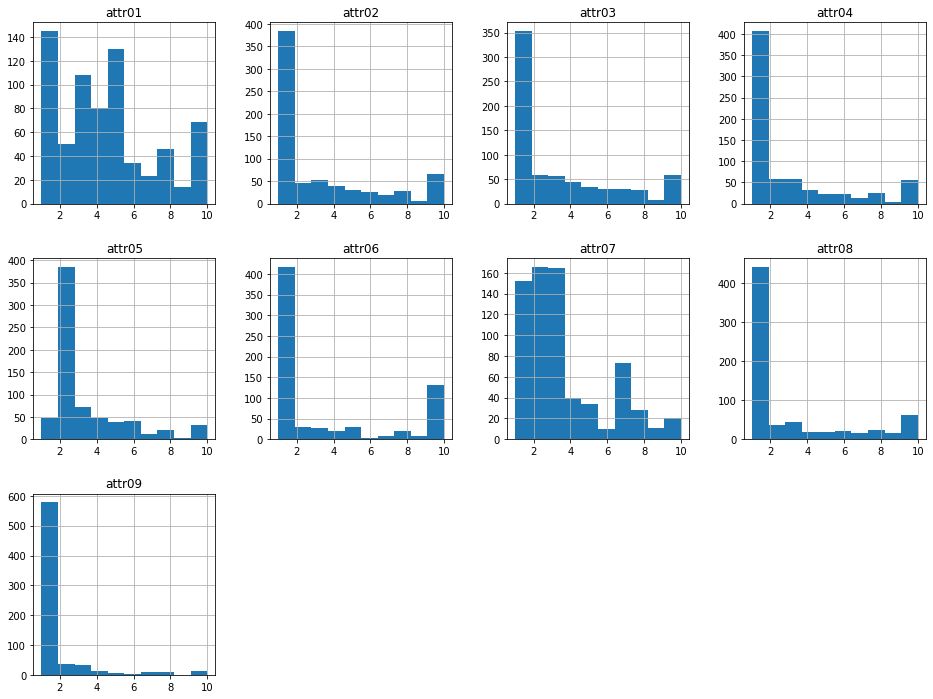

In [22]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [23]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['attr01', 'attr02', 'attr03', 'attr04', 'attr05', 'attr06', 'attr07', 'attr08', 'attr09']


In [24]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09
0,0.206936,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
1,0.206936,0.283845,0.266875,0.768621,1.710106,1.799664,-0.179662,-0.284112,-0.343912
2,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.410685,-0.179662,-0.611825,-0.343912
3,0.562336,1.595632,1.613773,-0.633247,-0.097628,0.141902,-0.179662,1.354454,-0.343912
4,-0.148465,-0.699995,-0.743299,0.067687,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
...,...,...,...,...,...,...,...,...,...
684,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
685,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
686,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
687,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.590067,0.043601,-0.343912


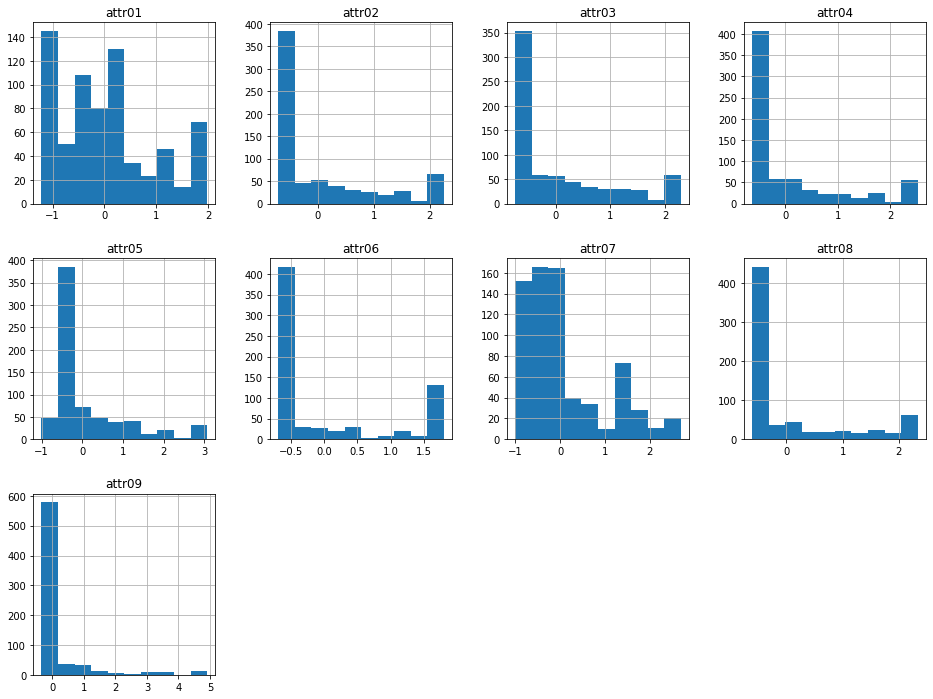

In [25]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [26]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [27]:
# Encode class values as integers and perform one-hot-encoding
# y_encoded = y_original.to_numpy()
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_encoded = encoder.transform(y_original)
print(y_encoded)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1
 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 1 1 1 0 1 0 

In [28]:
# Split the data further into training and test datasets
X_encoded = X_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (524, 9) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (524,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (175, 9) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (175,) y_test.type: <class 'numpy.ndarray'>


In [29]:
if (notifyStatus): email_notify("Task 2. Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [30]:
if (notifyStatus): email_notify("Task 3. Define and Fit Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
# Define the baseline model for benchmarking
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(15, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [32]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch,
                                   validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Train on 524 samples, validate on 175 samples
Epoch 1/25
524/524 [==============================] - 1s 2ms/sample - loss: 0.2325 - accuracy: 0.9141 - val_loss: 0.2198 - val_accuracy: 0.9257
Epoch 2/25
524/524 [==============================] - 0s 142us/sample - loss: 0.1923 - accuracy: 0.9466 - val_loss: 0.1890 - val_accuracy: 0.9257
Epoch 3/25
524/524 [==============================] - 0s 139us/sample - loss: 0.1643 - accuracy: 0.9523 - val_loss: 0.1671 - val_accuracy: 0.9314
Epoch 4/25
524/524 [==============================] - 0s 132us/sample - loss: 0.1445 - accuracy: 0.9580 - val_loss: 0.1516 - val_accuracy: 0.9314
Epoch 5/25
524/524 [==============================] - 0s 131us/sample - loss: 0.1312 - accuracy: 0.9561 - val_loss: 0.1401 - val_accuracy: 0.9314
Epoch 6/25
524/524 [==============================] - 0s 137us/sample - loss: 0.1210 - accuracy: 0.9599 - val_loss: 0.1318 - val_accuracy: 0.9314
Epoch 7/25
524/524 [==============================] - 0s 138us/sample - loss: 0.

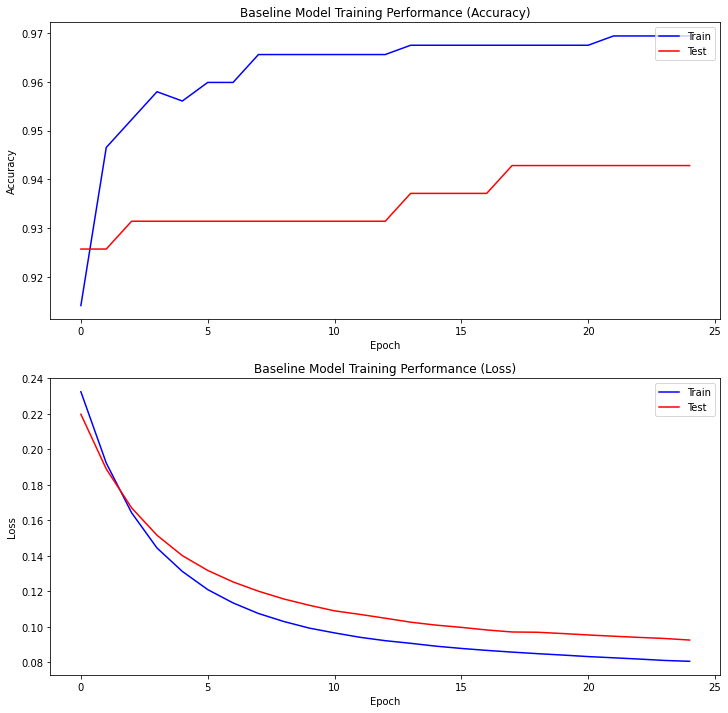

In [33]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [34]:
if (notifyStatus): email_notify("Task 3. Define and Fit Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [35]:
if (notifyStatus): email_notify("Task 4. Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [36]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(15, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [37]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [int(default_batch/2), default_batch, int(default_batch*2)]

best_score = 0
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d' 
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num,
                                           validation_data=(X_test, y_test), verbose=1)
                if(grid_hist.history['val_accuracy'][-1] > best_score):
                    best_score = grid_hist.history['val_accuracy'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (highest validation accuracy) found via grid search: accuracy=%f from model iteration #%d" 
      % (best_score, best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d' 
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f6ea047cb10>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f6ea047c550>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f6ea047c3d0>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f6ea047cc10>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f6ea0420210>
Initializer candidate #3 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f6ea04202d0>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f6ea047cb10>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f6ea047cc10>, epochs=25, batch_size=16
Train on 524 samples, validate 

In [38]:
best_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
best_kernel_init = tf.keras.initializers.RandomUniform(seed=seedNum)
best_epoch = 25
best_batch = 16

In [39]:
if (notifyStatus): email_notify("Task 4. Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [40]:
if (notifyStatus): email_notify("Task 5. Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
reset_random(seedNum)
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, validation_data=(X_test, y_test), verbose=1)

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f6e984967d0>, kernel=<tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f6e98496a90>, epochs=25, batch_size=16
Train on 524 samples, validate on 175 samples
Epoch 1/25
524/524 [==============================] - 1s 2ms/sample - loss: 0.6472 - accuracy: 0.9580 - val_loss: 0.5978 - val_accuracy: 0.9600
Epoch 2/25
524/524 [==============================] - 0s 229us/sample - loss: 0.5439 - accuracy: 0.9695 - val_loss: 0.4820 - val_accuracy: 0.9714
Epoch 3/25
524/524 [==============================] - 0s 224us/sample - loss: 0.4235 - accuracy: 0.9676 - val_loss: 0.3613 - val_accuracy: 0.9714
Epoch 4/25
524/524 [==============================] - 0s 233us/sample - loss: 0.3125 - accuracy: 0.9656 - val_loss: 0.2617 - val_accuracy: 0.9714
Epoch 5/25
524/524 [==============================] - 0s 229us/sample - loss: 0.2259 - accuracy: 0.9656 - val_loss: 0.1886 - val_accuracy: 0.9

In [42]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 15)                150       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 16        
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_28', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_56', 'trainable': True, 'batch_input_shape': (None, 9), 'dtype': 'float32', 'units': 15, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_57', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


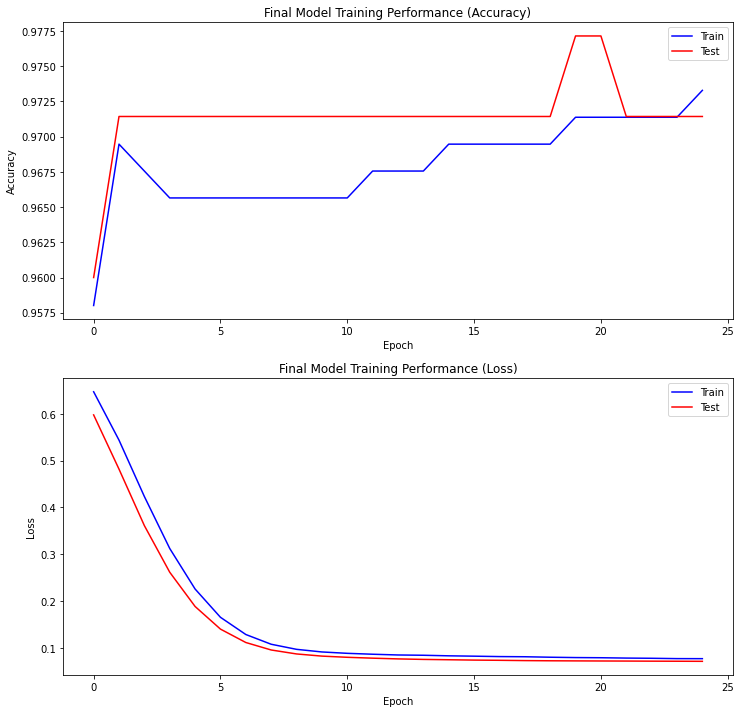

In [44]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(final_hist.history['accuracy'], color='blue', label='train')
plt.plot(final_hist.history['val_accuracy'], color='red', label='test')
plt.title('Final Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(final_hist.history['loss'], color='blue', label='train')
plt.plot(final_hist.history['val_loss'], color='red', label='test')
plt.title('Final Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %f" % (final_model.metrics_names[0], scores[0]))

175/175 [==============================] - 0s 87us/sample - loss: 0.0714 - accuracy: 0.9714

accuracy: 97.142857%

loss: 0.071381


In [46]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %d (expected %d)' % (i, predictions[i], y_test[i]))

Data item #0 predicted to be 1 (expected 1)
Data item #1 predicted to be 1 (expected 1)
Data item #2 predicted to be 1 (expected 1)
Data item #3 predicted to be 0 (expected 0)
Data item #4 predicted to be 0 (expected 0)
Data item #5 predicted to be 1 (expected 1)
Data item #6 predicted to be 0 (expected 0)
Data item #7 predicted to be 1 (expected 1)
Data item #8 predicted to be 0 (expected 0)
Data item #9 predicted to be 1 (expected 1)
Data item #10 predicted to be 0 (expected 0)
Data item #11 predicted to be 1 (expected 1)
Data item #12 predicted to be 0 (expected 0)
Data item #13 predicted to be 0 (expected 0)
Data item #14 predicted to be 0 (expected 0)
Data item #15 predicted to be 0 (expected 0)
Data item #16 predicted to be 0 (expected 0)
Data item #17 predicted to be 0 (expected 0)
Data item #18 predicted to be 0 (expected 0)
Data item #19 predicted to be 0 (expected 0)


In [47]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:44.115488
